# Intent Classifier

Labels:
- 'Ligar aparelho'
- 'Desligar aparelho'
- 'Criar regra'

## Setup

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
!python -m spacy download pt

     |████████████████████████████████| 12.9MB 257kB/s 
  Running setup.py install for pt-core-news-sm ... done
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/Users/LeoWajnsztok/.pyenv/versions/ds/lib/python3.6/site-packages/pt_core_news_sm
-->
/Users/LeoWajnsztok/.pyenv/versions/ds/lib/python3.6/site-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [32]:
import pandas as pd
import numpy as np

## Load dataset

In [33]:
initial_df = pd.read_csv('../data/initial_dataset_22022018.csv')

## Preprocess dataset

### Create a data/label dataframe

In [34]:
initial_df.head(3)

,Ligar um aparelho,Entities,Desligar um aparelho,Criar uma regra
0,Liga a televisão por favor.,televisao<B-DEVICE>,Desligue a luz do quarto por favor.,Ligue o ar condicionado as 3 da tarde hoje.
1,Ligue o ar condicionado.,ar<B-DEVICE>;condicionado<L-DEVICE>,Desligar a TV.,"Ligar a luz das 15 às 18 horas, todo dia."
2,Ar condicionado ligado.,ar<B-DEVICE>;condicionado<L-DEVICE>,Desliga o ar condicionado.,Apagar as luzes do quarto as 22 horas.


In [35]:
ligar_df = pd.DataFrame()
ligar_df['phrase'] = initial_df['Ligar um aparelho']
ligar_df['label'] = 'ligar_um_aparelho'
ligar_df = ligar_df.dropna()

desligar_df = pd.DataFrame()
desligar_df['phrase'] = initial_df['Desligar um aparelho']
desligar_df['label'] = 'desligar_um_aparelho'
desligar_df = desligar_df.dropna()

regra_df = pd.DataFrame()
regra_df['phrase'] = initial_df['Criar uma regra']
regra_df['label'] = 'criar_regra'
regra_df = regra_df.dropna()

df = ligar_df.append(desligar_df).append(regra_df)

df["label"] = df["label"].astype('category')
df["label_cat"] = df["label"].cat.codes

In [36]:
print (df.shape)
print (df.groupby('label').size())


(311, 3)
label
criar_regra              83
desligar_um_aparelho    100
ligar_um_aparelho       128
dtype: int64


In [37]:
df.head(1)

,phrase,label,label_cat
0,Liga a televisão por favor.,ligar_um_aparelho,2


### Clean dataset
- Lower sentences
- Remove accents
- Apply stemmer

In [38]:
df['phrase'] = df['phrase'].str.lower()
df['phrase'] = df['phrase'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [39]:
import nltk
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/LeoWajnsztok/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [40]:
df['phrase'] = df['phrase'].apply(lambda x: ' '.join([stemmer.stem(s) for s in x.split(' ')]))
df.head(2)

,phrase,label,label_cat
0,lig a televisa por favor.,ligar_um_aparelho,2
1,lig o ar condicionado.,ligar_um_aparelho,2


## Train and test split

In [41]:
from sklearn.model_selection import train_test_split

trainData, testData, trainLabels, testLabels = train_test_split(df['phrase'], df['label_cat'], test_size=0.2, random_state=42)


In [42]:
len(trainData), len(testData), len(trainLabels), len(testLabels)

(248, 63, 248, 63)

## Classification models and parameters

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

models = [
    ('GradientBoostingClassifier', GradientBoostingClassifier(), {}),
    ('LinearSVC', LinearSVC(), {}),
    ('SGD', SGDClassifier(), {}),
]


## Cross-validation with Pipeline and GridSearch

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import strip_accents_ascii
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

results = []
names = []
best_model = None
max_score = -1
labels_list = ['criar_regra', 'desligar_um_aparelho', 'ligar_um_aparelho']

for name, model, cls_params in models:
    parameters = {
      'vect__ngram_range': [(1, 1), (1, 2),],
      'vect__max_features': (200, 300),
      'vect__max_df': (0.5, 0.75, 1.0),
      'tfidf__use_idf': (True, False),
      'tfidf__norm': ('l1', 'l2'),
    }
  
    parameters.update(cls_params)
    pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', model)])
  
    gs_cls = GridSearchCV(pipe, parameters, n_jobs=1)
    gs_cls = gs_cls.fit(trainData, trainLabels)
  
    print ("Model: "+ name)
    print ("Best cross-validation score: " + str(gs_cls.best_score_))
    print ("Best parameters: " + str(gs_cls.best_params_))
    predictions = gs_cls.predict(testData)
    score = gs_cls.score(testData, testLabels)
    if score > max_score:
        max_score = score
    best_model = gs_cls

    print ("Accuracy: " + str(score))
    cm = confusion_matrix(testLabels, predictions)
    for i, l in enumerate(cm):
        print ('{0: <25} {1}'.format(labels_list[i], ''.join(['{0: <3}'.format(x) for x in l])))
    print (classification_report(testLabels, predictions))

    result_df = pd.DataFrame(list(zip(testData,testLabels)))
    result_df['pred'] = predictions
    result_df[result_df[1] != result_df['pred']]

    names.append(name)
    results.append(score)
    model = gs_cls

Model: GradientBoostingClassifier
Best cross-validation score: 0.8467741935483871
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Accuracy: 0.873015873015873
criar_regra               13 1  1  
desligar_um_aparelho      0  16 3  
ligar_um_aparelho         1  2  26 
             precision    recall  f1-score   support

          0       0.93      0.87      0.90        15
          1       0.84      0.84      0.84        19
          2       0.87      0.90      0.88        29

avg / total       0.87      0.87      0.87        63

Model: LinearSVC
Best cross-validation score: 0.8588709677419355
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Accuracy: 0.9047619047619048
criar_regra               11 0  4  
desligar_um_aparelho      0  18 1  
ligar_um_aparelho         0  1  28 
             precision    recall

## Results

### Models accuracy

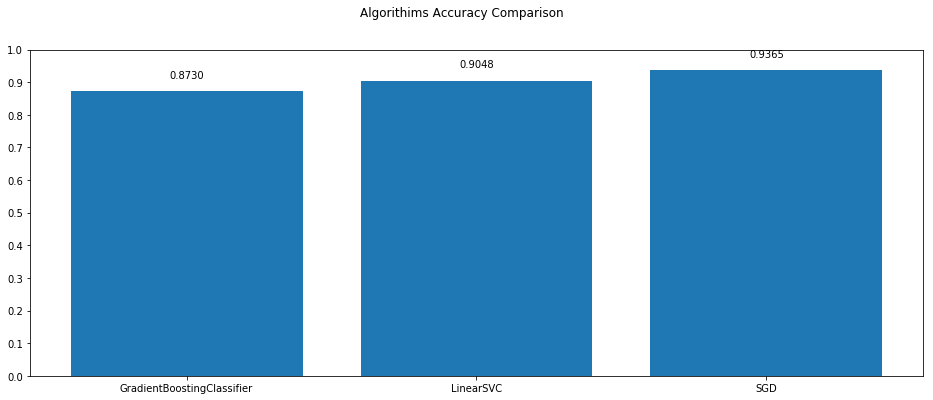

In [44]:
import matplotlib
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(16, 6))
fig.suptitle('Algorithims Accuracy Comparison')
plt.bar(names, results, )
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
for i, v in enumerate(names):
    ax.text(v, results[i] + 0.05, '%.4f' %(results[i]), ha='center', va='center')

    
plt.show()

In [47]:
# import nltk
# import unidecode
# nltk.download('rslp')
# stemmer = nltk.stem.RSLPStemmer()


def predict(sent):
    sent = sent.lower()
#   sent = unidecode.unidecode(sent)
    sent =  sent.encode('ascii', errors='ignore').decode('utf-8')
    sent = ' '.join([stemmer.stem(s) for s in sent.split(' ')])
    return labels_list[best_model.predict([sent])[0]]


In [48]:
print (predict('liga o ar ai por favor'))

ligar_um_aparelho


In [54]:
print (predict('ta na hora de apagar a luz.'))

desligar_um_aparelho


## Save model

In [56]:
import pickle

filename = '../models/intent_model.sav' 
with open(filename, 'wb') as f:
    pickle.dump(best_model, f, protocol=2)